In [14]:
import pickle
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
parameters = {
    'path': os.path.dirname(sys.path[0]),
    'path_in': os.path.join(os.path.dirname(sys.path[0]), '01_data'),
    'path_out': os.path.join(os.path.dirname(sys.path[0]), '02_output')
}

In [16]:
# Función para desempaquetar los archivos
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Lista para almacenar los datos
batches = []

# Update the data_dir path to the correct directory path
data_dir = os.path.join(parameters['path_in'], 'cifar-10-batches-py')

# Cargar cada archivo en la carpeta
for filename in os.listdir(data_dir):
    if filename.startswith('data_batch'):
        file_path = os.path.join(data_dir, filename)
        print(filename)
        data_dict = unpickle(file_path)
        batches.append(data_dict)

# Ahora 'data' es una lista con todas las imágenes del conjunto de datos
print(f'Número total de batches procesados: {len(batches)}')

data_batch_1
data_batch_2
data_batch_5
data_batch_4
data_batch_3
Número total de batches procesados: 5


In [17]:
# Extraer la data y las etiquetas
data = np.vstack([batch[b'data'] for batch in batches])
labels = np.hstack([batch[b'labels'] for batch in batches])

In [18]:
meta_data = unpickle(os.path.join(data_dir, 'batches.meta'))
label_meta = meta_data[b'label_names']
label_mapping = {i: label_meta[i].decode('utf-8') for i in range(len(label_meta))}

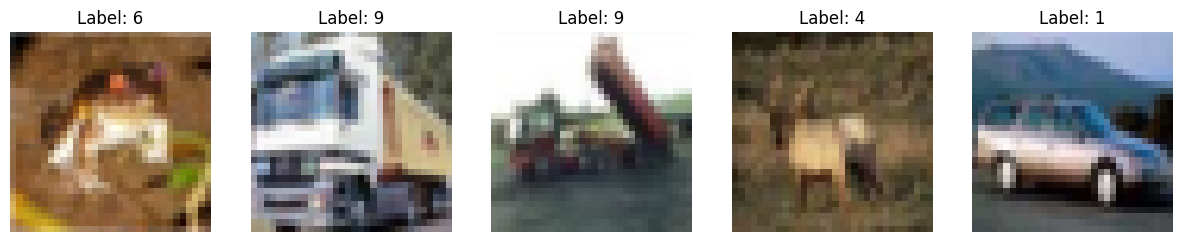

In [22]:
# Función para convertir los datos planos en imágenes de 32x32x3
def unpack_image(data, index):
    image = data[index].reshape(3, 32, 32).transpose(1, 2, 0)
    return image

# Visualizar las primeras 5 imágenes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    img = unpack_image(data, i)
    ax.imshow(img)
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.show()

In [ ]:
# Convertir la lista en un array de numpy
data_array = np.array(data)

# Convertir el array en un DataFrame de pandas
df = pd.DataFrame(data_array)
df["labels"] = labels
df["label_name"] = df["labels"].map(label_mapping)
df

,0,1,2,3,4,5,6,7,8,9,...,3064,3065,3066,3067,3068,3069,3070,3071,labels,label_name
0,59,43,50,68,98,119,139,145,149,149,...,65,59,46,57,104,140,84,72,6,frog
1,154,126,105,102,125,155,172,180,142,111,...,67,101,122,133,136,139,142,144,9,truck
2,255,253,253,253,253,253,253,253,253,253,...,80,69,66,72,79,83,83,84,9,truck
3,28,37,38,42,44,40,40,24,32,43,...,59,42,44,48,38,28,37,46,4,deer
4,170,168,177,183,181,177,181,184,189,189,...,85,82,83,79,78,82,78,80,1,automobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,25,25,26,27,27,27,28,29,29,28,...,176,175,175,175,175,175,178,155,2,bird
49996,65,66,69,73,75,72,68,65,63,62,...,48,48,48,44,40,39,38,36,5,dog
49997,175,200,207,206,191,174,157,151,146,97,...,202,164,138,98,118,124,49,32,3,cat
49998,28,59,67,71,30,59,71,49,45,58,...,35,49,58,54,48,36,44,41,7,horse


In [ ]:
df.value_counts("label_name")

label_name
airplane      5000
automobile    5000
bird          5000
cat           5000
deer          5000
dog           5000
frog          5000
horse         5000
ship          5000
truck         5000
Name: count, dtype: int64

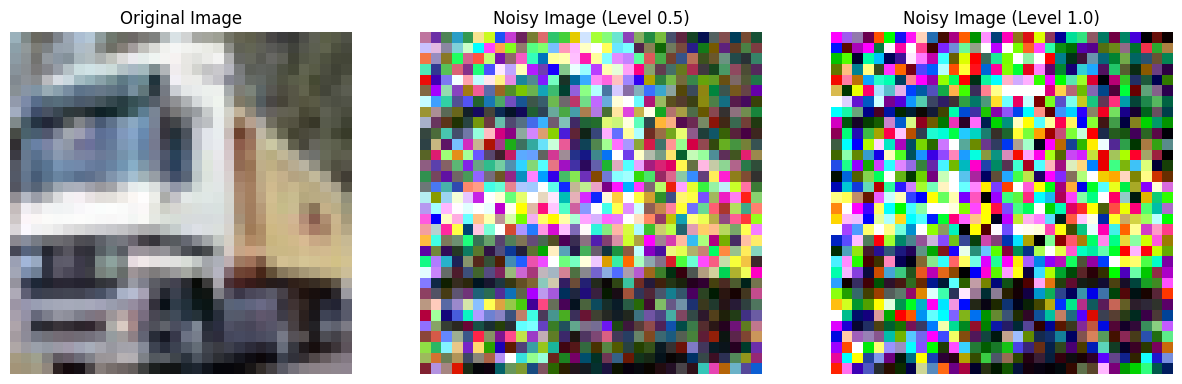

In [67]:
def add_speckle_noise(image, noise_level):
    # Generar ruido speckle
    noise = noise_level * np.random.randn(*image.shape)
    noisy_image = image + image * noise
    noisy_image = np.clip(noisy_image, 0, 255)  # Asegurar que los valores de píxel sigan siendo válidos
    return noisy_image.astype(np.uint8)

# Aplicar ruido speckle a la primera imagen con dos niveles diferentes de ruido
noise_levels = [0.5, 1.0]  # Desviación estándar para el ruido medio y alto
original_image = unpack_image(data, 1)
noisy_images = [add_speckle_noise(original_image, level) for level in noise_levels]

# Mostrar la imagen original y las imágenes con ruido
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, ax in enumerate(axes[1:], start=1):
    ax.imshow(noisy_images[i-1])
    ax.set_title(f'Noisy Image (Level {noise_levels[i-1]})')
    ax.axis('off')

plt.show()

In [60]:
# Generar ruido speckle para todas las imágenes en datasets diferentes
noisy_data_dir = os.path.join(parameters['path_out'], 'noisy-data')
os.makedirs(noisy_data_dir, exist_ok=True)

df_noisy_medium = pd.DataFrame()
df_noisy_high = pd.DataFrame()
data_medium = []
data_high = []

# Generar ruido speckle para todas las imágenes
for i, image in enumerate(data):
    noisy_image_medium = add_speckle_noise(unpack_image(data, i), 0.5).transpose(2, 0, 1).reshape(-1)
    label_noisy_image_medium = labels[i]
    noisy_image_high = add_speckle_noise(unpack_image(data, i), 1.0).transpose(2, 0, 1).reshape(-1)
    label_noisy_image_high = labels[i]

    data_medium.append(noisy_image_medium)
    data_high.append(noisy_image_high)


In [64]:
data_medium

[array([ 77,  23,  28, ..., 150, 118, 115], dtype=uint8),
 array([166,  53, 116, ...,  32, 168,  81], dtype=uint8),
 array([255, 255, 211, ...,   0,  53,  67], dtype=uint8),
 array([35, 41, 43, ...,  5, 42, 28], dtype=uint8),
 array([165, 146, 148, ...,  95,  61,  80], dtype=uint8),
 array([206, 164,  62, ...,   0,   4,   8], dtype=uint8),
 array([255, 104, 137, ...,  38,  35,  82], dtype=uint8),
 array([ 14,  26,  56, ..., 147,  67,   2], dtype=uint8),
 array([ 79,  83, 125, ...,  92,   5, 205], dtype=uint8),
 array([105, 123, 116, ...,  37, 104, 118], dtype=uint8),
 array([49, 39, 39, ..., 30, 45, 59], dtype=uint8),
 array([ 24, 186, 224, ..., 159, 135, 166], dtype=uint8),
 array([134, 162, 179, ...,  90,  46,  66], dtype=uint8),
 array([21, 12,  9, ..., 14, 21, 14], dtype=uint8),
 array([172,  73,  17, ..., 117, 132, 144], dtype=uint8),
 array([197,  92,  64, ..., 177,  77,  59], dtype=uint8),
 array([228, 255, 255, ...,  15,  12,  20], dtype=uint8),
 array([151,  99,  28, ...,  92,